In [1]:
using Random
using Plots
using Distributions
using AdaptiveSurveillance

In [2]:
const output_path = joinpath(dirname(pathof(AdaptiveSurveillance)), "..", "results", "tmp")
const L = 2
const p0 = [0.01, 0.02] # 0.01 * ones(L)
const β = 4e-6 * 536 * 7
const p = repeat(prevalance_sequence(p0[1], β), 1, L) # fix this
const n = 200

200

In [3]:
ν = 1 / (26) # approx 6 months until there is an outbreak
Γd = [Geometric(ν) for l = 1:L]

2-element Array{Geometric{Float64},1}:
 Geometric{Float64}(p=0.038461538461538464)
 Geometric{Float64}(p=0.038461538461538464)

In [4]:
α = 10000 # the higher, the less false positives

10000

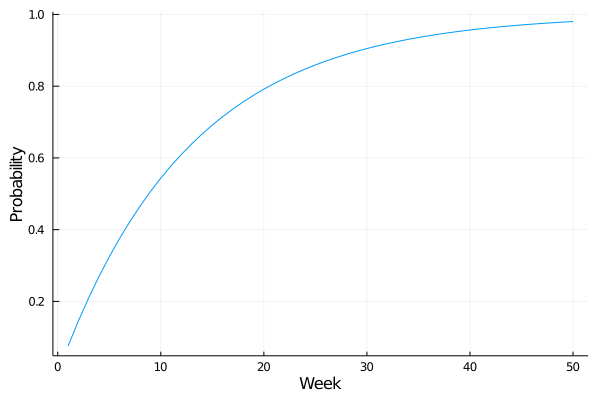

In [5]:
# Probability of any change point over time
Γd_all = Geometric(1 - prod(1 .- succprob.(Γd)))
plot(1:50, cdf.(Γd_all, 0:(49)), legend = false, ylabel = "Probability", xlabel = "Week")

In [6]:
# Debug
Γ = [0, typemax(Int64)]
beta_parameters = ones(L, 2)
recent_beta_parameters = ones(L, 2)
t, la, false_alarm, delay, test_data, locations_visited, ntimes_visisted, 
    last_time_visited, z, w, prevalance_history = replication(L, Γ, p0, p, n,
    astat_isotonic, α, tpolicy_evsi, tstate_evsi(Γd, beta_parameters, recent_beta_parameters),
    rng1 = MersenneTwister(1), rng2 = MersenneTwister(2), maxiters = 1000);

In [15]:
plot(0:(t-1), prevalance_history[1:t, :] * 100, label = ["Location 1" "Location 2"],
    xlabel = "Week", ylabel = "Prevalence (%)", legend = :topleft)
vline!([46], label = "Clairvoyant sampling switches to location 1")
savefig(joinpath(output_path, "prevalance_seq.pdf"))

In [107]:
replace!(test_data, -1=>NaN)
bar(1:(t-1), test_data[1:(t-1), :], xlabel = "Week", ylabel = "Positive Count", labels = ["Location 1" "Location 2" "l3"])
vline!([20], label = "Outbreak Start in Location 1")
savefig(joinpath(output_path, "positive_counts.pdf"))

In [108]:
plot(2:(t-1), hcat(z[3:t, :], repeat([log(α)], t-2)), xlabel = "Week", ylabel = "Alarm Statistic", 
    label = [permutedims(["Location $l" for l = 1:L])... "Threshold"], legend=:topleft)
vline!([20], label = "Outbreak Start in Location 1")
savefig(joinpath(output_path, "alarm_stat.pdf"))

In [53]:
# Alarm time distribution
atd_T = 200
atd_0 = alarm_time_distribution(Int(1e6), L, zeros(Int64, L), p0, p, n, astat_isotonic, α, 
    tpolicy_constant, tstate_const(2), maxiters=atd_T);
atd_0 = cumsum(atd_0) ./ sum(atd_0);

In [54]:
atd_1 = alarm_time_distribution(Int(1e6), L, ones(Int64, L) * typemax(Int64), p0, p, n, astat_isotonic, α, 
    tpolicy_constant, tstate_const(2), maxiters=atd_T);
atd_1 = cumsum(atd_1) ./ sum(atd_1);

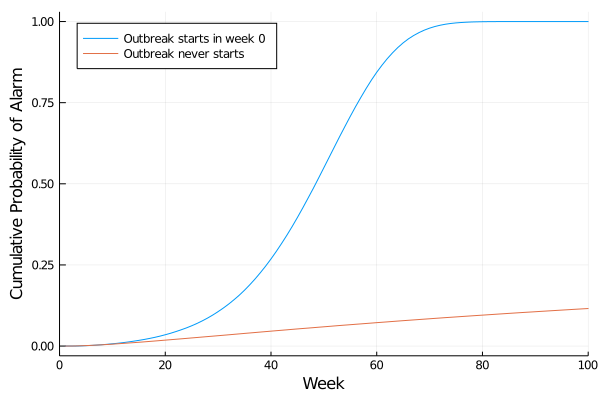

In [58]:
plot(1:atd_T, hcat(atd_0[1:atd_T], atd_1[1:atd_T]), label = ["Outbreak starts in week 0" "Outbreak never starts"], legend=:topleft,
    xlim=(0, 100), xlabel = "Week", ylabel = "Cumulative Probability of Alarm")

In [59]:
savefig(joinpath(output_path, "alarm_time_distr.pdf"))

In [10]:
# Probability of successful detection
T_end = 21

21

In [11]:
sp2s, hw2s = probability_successfull_detection_l(Int(1e4), T_end, 47, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_constant, tstate_const(1));
sp3s, hw3s = probability_successfull_detection_l(Int(1e4), T_end, 75, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_constant, tstate_const(1));

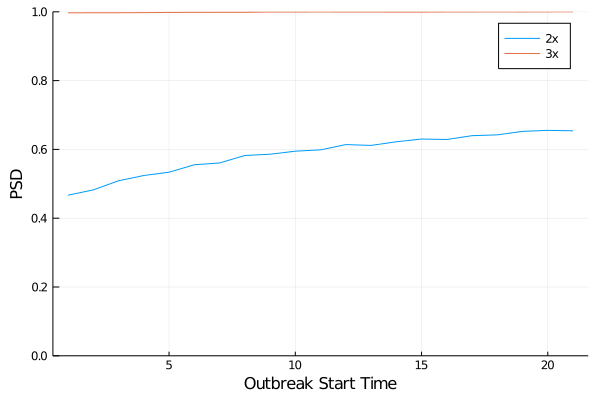

In [12]:
plot(1:T_end, hcat(sp2s, sp3s), label = ["2x" "3x"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))

In [13]:
sp2r, hw2r = probability_successfull_detection_l(Int(1e4), T_end, 47, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_random, nothing);
sp3r, hw3r = probability_successfull_detection_l(Int(1e4), T_end, 75, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_random, nothing);

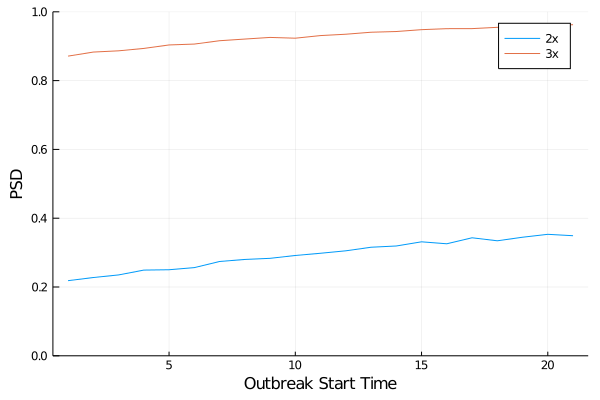

In [14]:
plot(1:T_end, hcat(sp2r, sp3r), label = ["2x" "3x"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))

In [15]:
# thompson sampling
sp2ts, hw2ts = probability_successfull_detection_l(Int(1e4), T_end, 47, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_thompson, tstate_thompson(ones(L, 2)));
sp3ts, hw3ts = probability_successfull_detection_l(Int(1e4), T_end, 75, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_thompson, tstate_thompson(ones(L, 2)));

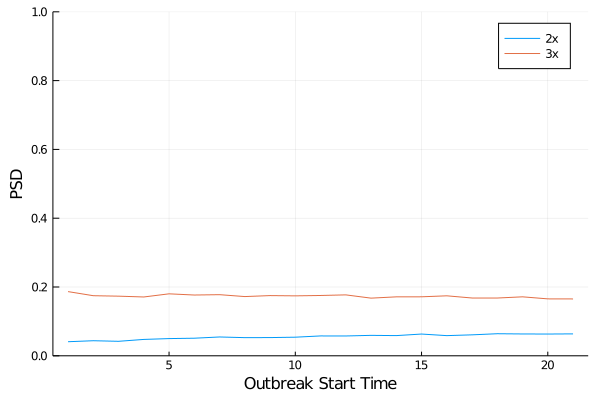

In [16]:
plot(1:T_end, hcat(sp2ts, sp3ts), label = ["2x" "3x"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))

In [17]:
sp2vi, hw2vi = probability_successfull_detection_l(Int(1e4), T_end, 47, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_evsi, tstate_evsi(Γd, ones(L, 2), ones(L, 2)));
sp3vi, hw3vi = probability_successfull_detection_l(Int(1e4), T_end, 75, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_evsi, tstate_evsi(Γd, ones(L, 2), ones(L, 2)));

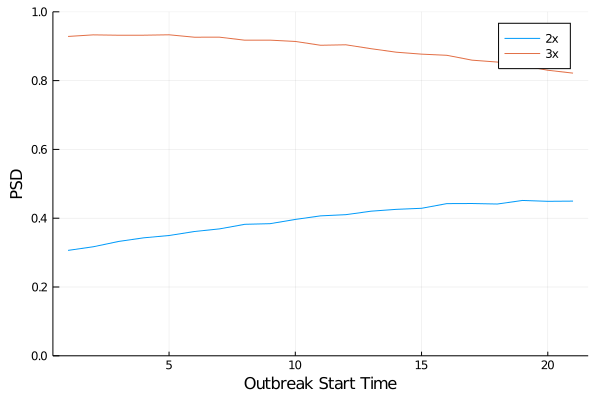

In [18]:
plot(1:T_end, hcat(sp2vi, sp3vi), label = ["2x" "3x"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))

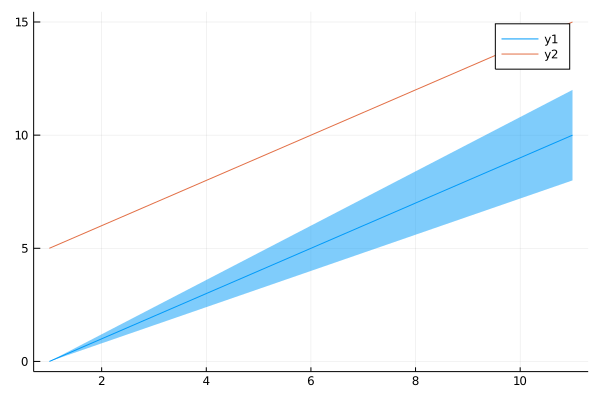

In [35]:
plot(hcat(0:10, 5:15); ribbon = [LinRange(0, 2, 11) LinRange(0, 0, 11)])


In [43]:
plot(1:T_end, sp2s, ribbon = hw2s, ylim=(0, 1), label = "Upper Bound", xlabel = "Outbreak Start Week",
    ylabel = "Probability of Successful Detection", svg = true)
savefig(joinpath(output_path, "upper_bound_psd.pdf"))

In [45]:
plot(1:T_end, hcat(sp2s, sp2r), ribbon = hcat(hw2s, hw2r), ylim=(0, 1), label = ["Upper Bound" "Uniform Random"], xlabel = "Outbreak Start Week",
    ylabel = "Probability of Successful Detection", svg = true)
savefig(joinpath(output_path, "random_psd.pdf"))

In [48]:
plot(1:T_end, hcat(sp2s, sp2r, sp2ts), ribbon = hcat(hw2s, hw2r, hw2ts), ylim=(0, 1), 
    label = ["Upper Bound" "Uniform Random" "Thompson Sampling"], xlabel = "Outbreak Start Week",
    ylabel = "Probability of Successful Detection", svg = true)
savefig(joinpath(output_path, "thompson_psd.pdf"))

In [50]:
plot(1:T_end, hcat(sp2s, sp2r, sp2ts, sp2vi), ribbon = hcat(hw2s, hw2r, hw2ts, hw2vi), ylim=(0, 1), 
    label = ["Upper Bound" "Uniform Random" "Thompson Sampling" "Value of Information"], xlabel = "Outbreak Start Week",
    ylabel = "Probability of Successful Detection", svg = true)
savefig(joinpath(output_path, "voi_psd.pdf"))

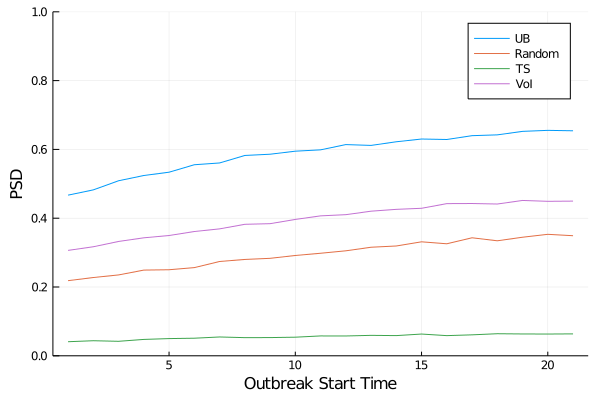

In [19]:
plot(1:T_end, hcat(sp2s, sp2r, sp2ts, sp2vi), label = ["UB" "Random" "TS" "VoI"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))

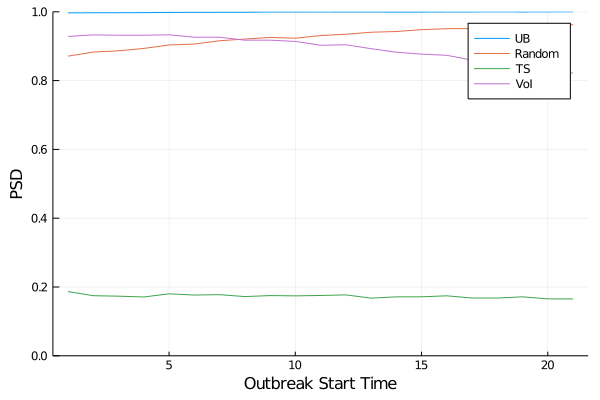

In [20]:
plot(1:T_end, hcat(sp3s, sp3r, sp3ts, sp3vi), label = ["UB" "Random" "TS" "VoI"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))